## **PRACTICAL SESSION 1** — Deep Learning for predictive maintenance

The dataset used is the **AI4I 2020** Predictive Maintenance Dataset, which contains 10,000 instances of industrial sensor data. Each instance represents the operating condition of a machine and is associated with a label indicating whether a failure has occurred and, if so, what type of failure it is.

The 5 possible labels are:



*   **TWF**: Tool Wear Failure
*   **HDF**: Heat Dissipation Failure
*   **PWF**: Power Failure
*   **OSF**: Overstrain Failure
*   **RNF**: Random Failure


The data is available on eCAMPUS as CSV file called: "ai4i2020.csv"



## **PRACTICAL SESSION Goal** — Ceate a deep leanring model allowing to realize a predictive maintenance mission


## **1 - Analysis of the dataset**



All libraries used ***SHOULD BE PLACED*** in the code cell below

In [ ]:
#Libraries
import pandas as pd
import numpy as np
!pip install tensorflow==2.12.0
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

**QUESTION:** Load dataset and display some lines of the csv file.

In [ ]:
df = pd.read_csv('sample_data/ai4i2020.csv')
print(df.head())

   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1    0    0    0    0  
2    0  

**QUESTION:** Display the distribution of machine failures and non-failures with a bar graph.

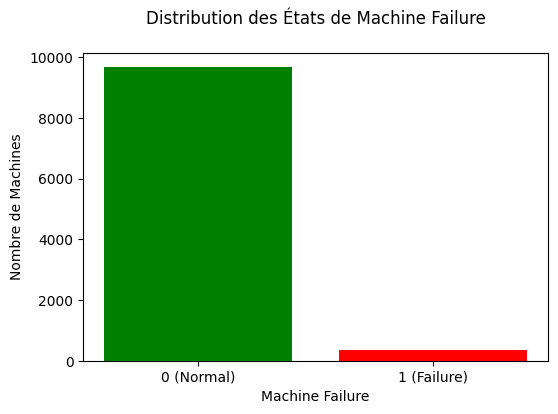

Nombre de machine: 10000
3.39% de machines en échec


In [ ]:
# Supposons que df['Machine failure'] contient des valeurs 0 et 1
counts = df['Machine failure'].value_counts().sort_index()  # Compte les occurrences de 0 et 1

# Calcul du pourcentage de machines en failure
total_machines = counts.sum()
failure_percentage = (counts.get(1, 0) / total_machines) * 100  # Évite les erreurs si '1' est absent

plt.figure(figsize=(6, 4))
plt.bar(counts.index.astype(str), counts.values, color=['green', 'red'])  # Vert pour 0, Rouge pour 1
plt.xlabel('Machine Failure')
plt.ylabel('Nombre de Machines')
plt.title(f'Distribution des États de Machine Failure\n')
plt.xticks([0, 1], ['0 (Normal)', '1 (Failure)'])
plt.show()

print(f'Nombre de machine:', total_machines)
print(f'{failure_percentage:.2f}% de machines en échec')


**ANALYSIS QUESTION:** What do you observe?

On constate que le nombre de machine en etat d'echec (Failure) est trés faible (3.39%).

**ANALYSIS QUESTION:** What will be the consequence of this phenomenon on the model's learning?

"Write here your response"

**QUESTION:** Create a bar chart showing the distribution of different failure types (TWF, HDF, PWF, OSF, RNF). Display the exact values above each bar in the chart."

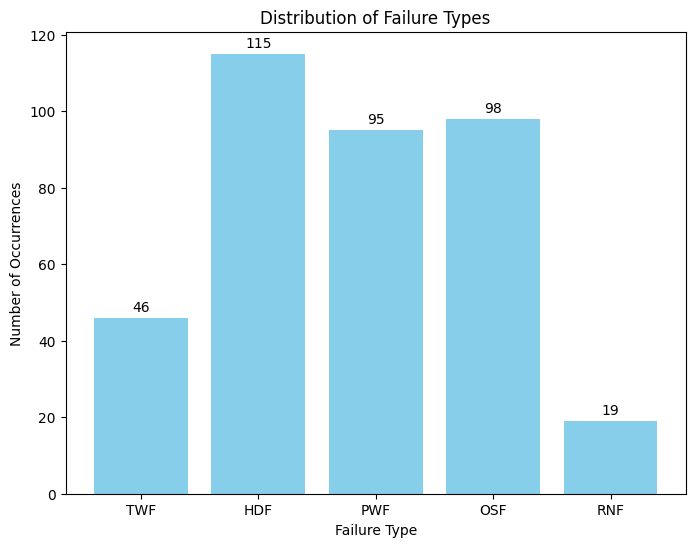

In [ ]:
failure_types = ["TWF", "HDF", "PWF", "OSF", "RNF"]

failure_counts = {failure: df[failure].sum() for failure in failure_types}

plt.figure(figsize=(8, 6))
bars = plt.bar(failure_counts.keys(), failure_counts.values(), color='skyblue')
plt.xlabel("Failure Type")
plt.ylabel("Number of Occurrences")
plt.title("Distribution of Failure Types")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom')

plt.show()

**ANALYSIS QUESTION:** What do you observe?

- Il y a plus d'erreurs de machine que de machines en panne. Cela est dû au fait que certaines archines ont deux types d'erreurs.
- On observe aussi qu'il y a que l'erreur la plus fréquente est HDF suivie de OSF et PWF, il faudrait donc agir sur ce type d'erreur pour pouvoir réduire drastiquement la portion de machine en mode failure.

**QUESTION:** Create a bar chart showing the distribution of failure types (TWF, HDF, PWF, OSF, RNF) among machines that experienced a failure (Machine failure == 1). Additionally, add a "No Specific Failure" category to count cases where a machine failed but no specific failure type was recorded. Display the exact values above each bar in the chart."

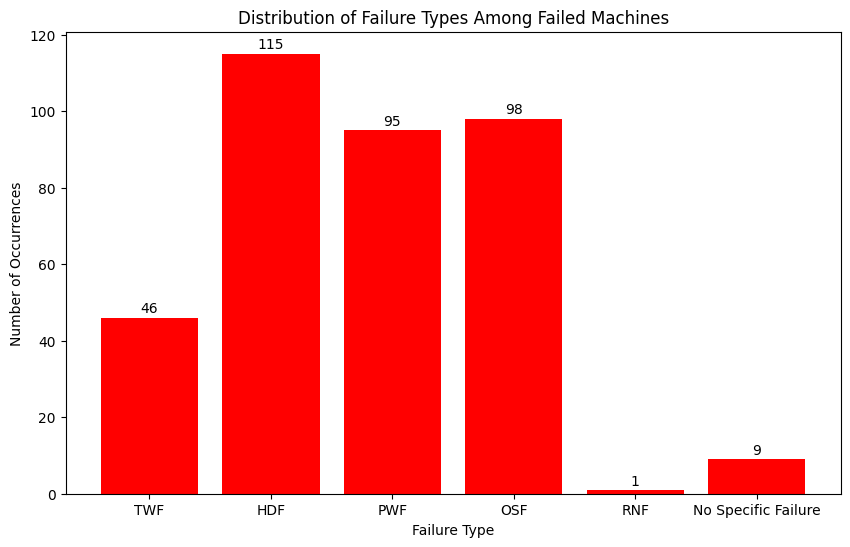

In [ ]:
failed_machines = df[df['Machine failure'] == 1]

failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']

failure_counts = {failure: failed_machines[failure].sum() for failure in failure_types}

no_specific_failure = (failed_machines[failure_types].sum(axis=1) == 0).sum()
failure_counts['No Specific Failure'] = no_specific_failure

plt.figure(figsize=(10, 6))
bars = plt.bar(failure_counts.keys(), failure_counts.values(), color='red')
plt.xlabel("Failure Type")
plt.ylabel("Number of Occurrences")
plt.title("Distribution of Failure Types Among Failed Machines")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom')

plt.show()

**ANALYSIS QUESTION:** What do you obsrve comapred to the previous question ? What can you conclude?

Le nombre d'erreurs de type RNF a diminué car une partie était des erreurs ne mettant pas la machine en failure. De plus, il y a 9 erreurs non spécifiques.

**QUESTION:** Display the names of the different columns in the dataset with their respective data types.

In [ ]:
df.dtypes


,0
UDI,int64
Product ID,object
Type,object
Air temperature [K],float64
Process temperature [K],float64
Rotational speed [rpm],int64
Torque [Nm],float64
Tool wear [min],int64
Machine failure,int64
TWF,int64


**ANALYSIS QUESTION:** To train the model, what will be the inputs and outputs (What are the names of the columns that you will use?)? Justify your response.
Remember, you want to predict if the machine will fail, and if so, what kind of failure. You need to yse previous results to jsurtify your response.

Le but est de faire de la maintenance prédictive, ainsi les paramètres à analyser sont les paramètres du processus des machines pour détecter des anomalies. Avec ces paramètres, nous pourrons prédire le type d'erreur qui seront donc les sorties.
- Sortie: Machine failure, TWF, HDF, PWF, OSF, RNF
- Entrée: Type, Air Temperature, Process Temperature, rotational speed, torque, tool wear

## **2- Train model Without balancing the dataset**

---



In this section, you must build and train a model without rebalancing the dataset.

**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [ ]:
num_classes = 6

# Définition des features (X) et des labels (Y)
X = df[['Type', 'Air temperature [K]', 'Process temperature [K]',
        'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']]

# Remplacement des valeurs de 'Type' par des nombres
mapping = {'L': 1, 'M': 2, 'H': 3}
X['Type'] = X['Type'].replace(mapping).astype(float)

# Définition de Y
Y = df[['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']]

# Filtrer les lignes où il y a plus d'un "1" dans Y
valid_rows = Y.sum(axis=1) <= 1
X = X[valid_rows]
Y = Y[valid_rows]

# Split des données
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Définition de X_val et Y_val
X_val = X_train.iloc[5000:]
Y_val = Y_train.iloc[5000:]

# Affichage des tailles des datasets
print("Nombre d'éléments dans X_train:", len(X_train))
print("Nombre d'éléments dans Y_train:", len(Y_train))
print("Nombre d'éléments dans X_test:", len(X_test))
print("Nombre d'éléments dans Y_test:", len(Y_test))
print("Nombre d'éléments dans X_val:", len(X_val))
print("Nombre d'éléments dans Y_val:", len(Y_val))

# Conversion en one-hot encoding
y_train = keras.utils.to_categorical(Y_train, num_classes)
y_test = keras.utils.to_categorical(Y_test, num_classes)
y_val = keras.utils.to_categorical(Y_val, num_classes)

Nombre d'éléments dans X_train: 7736
Nombre d'éléments dans Y_train: 7736
Nombre d'éléments dans X_test: 1934
Nombre d'éléments dans Y_test: 1934
Nombre d'éléments dans X_val: 2736
Nombre d'éléments dans Y_val: 2736


<ipython-input-137-116d2fc9a64b>:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['Type'] = X['Type'].replace(mapping).astype(float)
<ipython-input-137-116d2fc9a64b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Type'] = X['Type'].replace(mapping).astype(float)


**QUESTION** Code below the model architecture

In [ ]:
inputs = keras.Input(shape=(6)) #my input layer
x = keras.layers.Flatten()(inputs) #cf. question below...
x = keras.layers.Dense(30, activation='tanh')(x) #a first hidden layer with 20 neurons
outputs = keras.layers.Dense(6, activation='softmax')(x) # my output layer
#Then, I define my model with the input layer, the output layer and a name
my_mlp_model = keras.Model(inputs=inputs, outputs=outputs, name="my_mlp_model")

#PRINT A SUMMARY OF THE ARCHITECTURE OF MY MODEL WITH THE NUMBER OF TRAINABLE PARAMETERS
my_mlp_model.summary()

#(2) DEFINE THE TRAINING HYPER-PARAMETERS WITH THE "COMPILE" METHOD:
'''
(1) Set the "optimizer" [pick 'adam', 'sgd' or 'rmsprop']
(2) Set the loss [cf. lesson #3, we pick the categorical cross-entropy]
(3) Set the final performance metric to evaluate the model
'''

my_mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "my_mlp_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 6)]               0         
                                                                 
 flatten_28 (Flatten)        (None, 6)                 0         
                                                                 
 dense_56 (Dense)            (None, 30)                210       
                                                                 
 dense_57 (Dense)            (None, 6)                 186       
                                                                 
Total params: 396
Trainable params: 396
Non-trainable params: 0
_________________________________________________________________


**QUESTION** Code below the algorithms allowing to train model

**WARNING!** You need to plot the training and test accuracy and loss to check if our model is overfitting

Epoch 1/10
387/387 [==============================] - 2s 2ms/step - loss: 0.0043 - accuracy: 0.0019 - val_loss: 0.0042 - val_accuracy: 0.0011
Epoch 2/10
387/387 [==============================] - 1s 2ms/step - loss: 0.0043 - accuracy: 0.0019 - val_loss: 0.0041 - val_accuracy: 0.0011
Epoch 3/10
387/387 [==============================] - 1s 2ms/step - loss: 0.0043 - accuracy: 0.0019 - val_loss: 0.0041 - val_accuracy: 0.0011
Epoch 4/10
387/387 [==============================] - 1s 2ms/step - loss: 0.0043 - accuracy: 0.0019 - val_loss: 0.0041 - val_accuracy: 0.0011
Epoch 5/10
387/387 [==============================] - 1s 2ms/step - loss: 0.0043 - accuracy: 0.0019 - val_loss: 0.0041 - val_accuracy: 0.0011
Epoch 6/10
387/387 [==============================] - 1s 2ms/step - loss: 0.0043 - accuracy: 0.0019 - val_loss: 0.0041 - val_accuracy: 0.0011
Epoch 7/10
387/387 [==============================] - 1s 2ms/step - loss: 0.0043 - accuracy: 0.0019 - val_loss: 0.0041 - val_accuracy: 0.0011
Epoch 

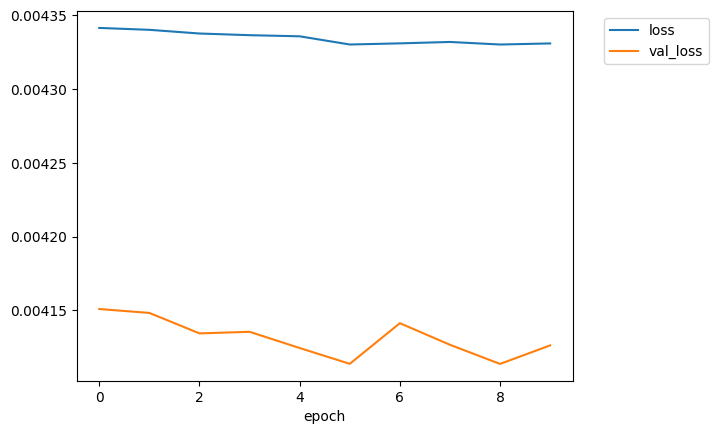

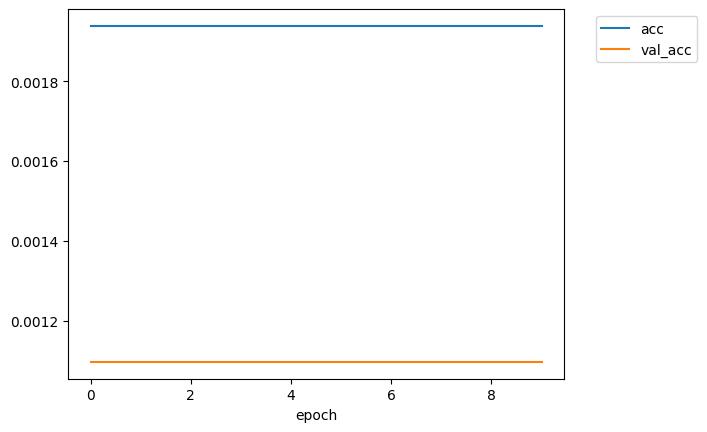

In [ ]:
#(3) NOW, LET'S TRAIN ON MY DATA WITH THE "FIT" METHOD
'''
(1) Set the number of epochs
(2) Set the size of the (mini)batch
(3) Set the training dataset ==> here, X_train with Y_train
(4) Set the validation dataset (X_val, Y_val)
'''
nb_epochs=10
batch_size=20
training_history = my_mlp_model.fit(X_train,Y_train,
                                    validation_data=(X_val, Y_val),
                                    epochs=nb_epochs,
                                    batch_size=batch_size)

#COMPUTE THE ACCURACY ON THE TRAINING AND TEST SETS
loss_train, acc_train = my_mlp_model.evaluate(X_train, Y_train, batch_size=batch_size)
loss_test, acc_test = my_mlp_model.evaluate(X_test, Y_test, batch_size=batch_size)

print("Performance on the TRAIN set, ACCURACY=",acc_train)
print("Performance on the TEST set, ACCURACY=",acc_test)

def display_training_curves(training_history):
  # display loss
  plt.plot(training_history.history['loss'],label='loss')
  plt.plot(training_history.history['val_loss'], label='val_loss')
  plt.xlabel("epoch")
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
  plt.show()
  #display accuracy
  plt.plot(training_history.history['accuracy'],label='acc')
  plt.plot(training_history.history['val_accuracy'], label='val_acc')
  plt.xlabel("epoch")
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
  plt.show()

display_training_curves(training_history)


**QUESTION** Plot the confusion matrix and the classification report

**Tips:**

*   classification report link

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

*   Matrix confusion

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html





61/61 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1931
           5       0.00      1.00      0.00         3

    accuracy                           0.00      1934
   macro avg       0.00      0.50      0.00      1934
weighted avg       0.00      0.00      0.00      1934



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


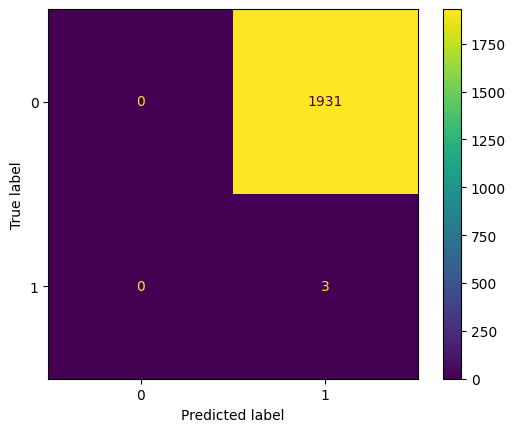

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

#TODO: PASSER en multiclasse
y_pred = my_mlp_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)

# Classification report
print(classification_report(y_true, y_pred_classes))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


**ANALYSIS QUESTION** What do you observe? What can you conclude?

Le model overfit ou underfit clairement dans une classe a cause du manque de donnée.

## **3- Train model With balancing the dataset**

---

 Methods for rebalancing a dataset:


*   Use oversampling techniques (e.g., SMOTE) to generate synthetic data for minority classes


> https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html



*   Apply undersampling techniques (e.g., random undersampling, Tomek Links, Edited Nearest Neighbors) to reduce the majority class size



> https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html



*   Use class weighting during model training to penalize errors on minority classes



> https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=fr


**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to oversample the minority class for 'Machine failure' only
smote = SMOTE(random_state=42)
# Use only the 'Machine failure' column as the target for SMOTE
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train['Machine failure'])

# Now, since Y_train_resampled only contains 'Machine failure',
# we need to get the other failure types corresponding to the resampled indices.
Y_train_resampled = pd.DataFrame(Y_train_resampled, columns=['Machine failure'])
Y_train_resampled = Y_train_resampled.merge(Y_train, left_index=True, right_index=True, how='left', suffixes=('_x', ''))
Y_train_resampled = Y_train_resampled[['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']]

# Split the resampled data into training and testing sets
X_train_2, X_test_2, Y_train_2, Y_test_2 = train_test_split(X_train_resampled, Y_train_resampled, test_size=0.2, random_state=42)

# Print the number of elements in each set
print("Number of elements in X_train:", len(X_train_2))
print("Number of elements in Y_train:", len(Y_train_2))
print("Number of elements in X_test:", len(X_test_2))
print("Number of elements in Y_test:", len(Y_test_2))

Number of elements in X_train: 12368
Number of elements in Y_train: 12368
Number of elements in X_test: 3092
Number of elements in Y_test: 3092


**ANALYSIS QUESTION:** Explain the choices you made to balance the dataset.

"Write your response here"

**QUESTION:** Code below the model architecture


**TIP:** It could be interesting to keep it the same as before

In [ ]:
inputs = keras.Input(shape=(6)) #my input layer
x = keras.layers.Flatten()(inputs) #cf. question below...
x = keras.layers.Dense(30, activation='tanh')(x) #a first hidden layer with 20 neurons
outputs = keras.layers.Dense(6, activation='softmax')(x) # my output layer
#Then, I define my model with the input layer, the output layer and a name
my_mlp_model = keras.Model(inputs=inputs, outputs=outputs, name="my_mlp_model")

#PRINT A SUMMARY OF THE ARCHITECTURE OF MY MODEL WITH THE NUMBER OF TRAINABLE PARAMETERS
my_mlp_model.summary()

#(2) DEFINE THE TRAINING HYPER-PARAMETERS WITH THE "COMPILE" METHOD:
'''
(1) Set the "optimizer" [pick 'adam', 'sgd' or 'rmsprop']
(2) Set the loss [cf. lesson #3, we pick the categorical cross-entropy]
(3) Set the final performance metric to evaluate the model
'''

my_mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "my_mlp_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 6)]               0         
                                                                 
 flatten_30 (Flatten)        (None, 6)                 0         
                                                                 
 dense_60 (Dense)            (None, 30)                210       
                                                                 
 dense_61 (Dense)            (None, 6)                 186       
                                                                 
Total params: 396
Trainable params: 396
Non-trainable params: 0
_________________________________________________________________


**QUESTION** Code below the algorithms allowing to train model


Epoch 1/20
619/619 [==============================] - 4s 4ms/step - loss: nan - accuracy: 0.9975 - val_loss: nan - val_accuracy: 0.9989
Epoch 2/20
619/619 [==============================] - 2s 3ms/step - loss: nan - accuracy: 0.9991 - val_loss: nan - val_accuracy: 0.9989
Epoch 3/20
619/619 [==============================] - 2s 4ms/step - loss: nan - accuracy: 0.9991 - val_loss: nan - val_accuracy: 0.9989
Epoch 4/20
619/619 [==============================] - 2s 3ms/step - loss: nan - accuracy: 0.9991 - val_loss: nan - val_accuracy: 0.9989
Epoch 5/20
619/619 [==============================] - 2s 3ms/step - loss: nan - accuracy: 0.9991 - val_loss: nan - val_accuracy: 0.9989
Epoch 6/20
619/619 [==============================] - 5s 7ms/step - loss: nan - accuracy: 0.9991 - val_loss: nan - val_accuracy: 0.9989
Epoch 7/20
619/619 [==============================] - 2s 4ms/step - loss: nan - accuracy: 0.9991 - val_loss: nan - val_accuracy: 0.9989
Epoch 8/20
619/619 [============================

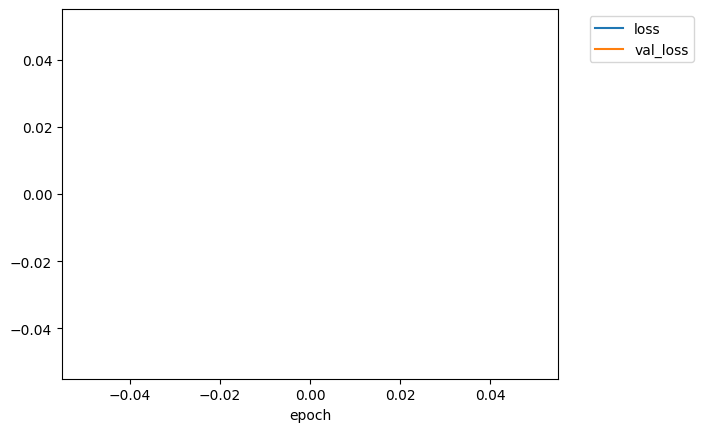

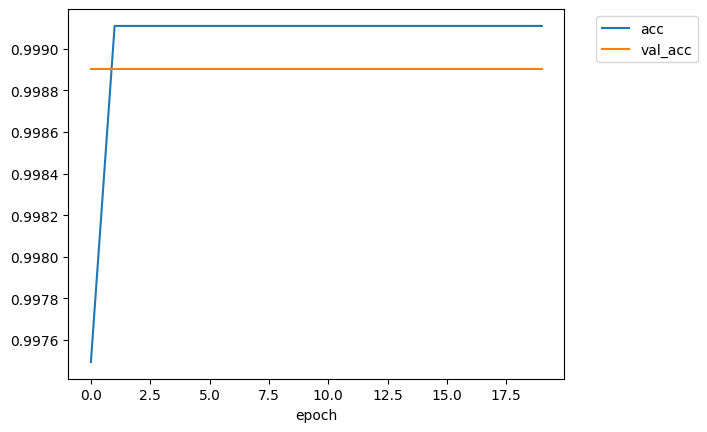

In [ ]:
#(3) NOW, LET'S TRAIN ON MY DATA WITH THE "FIT" METHOD

nb_epochs=20
batch_size=20
training_history = my_mlp_model.fit(X_train_2,Y_train_2,
                                    validation_data=(X_val, Y_val),
                                    epochs=nb_epochs,
                                    batch_size=batch_size)

#COMPUTE THE ACCURACY ON THE TRAINING AND TEST SETS
loss_train, acc_train = my_mlp_model.evaluate(X_train_2, Y_train_2, batch_size=batch_size)
loss_test, acc_test = my_mlp_model.evaluate(X_test_2, Y_test_2, batch_size=batch_size)

print("Performance on the TRAIN set, ACCURACY=",acc_train)
print("Performance on the TEST set, ACCURACY=",acc_test)

def display_training_curves(training_history):
  # display loss
  plt.plot(training_history.history['loss'],label='loss')
  plt.plot(training_history.history['val_loss'], label='val_loss')
  plt.xlabel("epoch")
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
  plt.show()
  #display accuracy
  plt.plot(training_history.history['accuracy'],label='acc')
  plt.plot(training_history.history['val_accuracy'], label='val_acc')
  plt.xlabel("epoch")
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
  plt.show()

display_training_curves(training_history)


**QUESTION** Plot the confusion matrix and the classification report

97/97 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3088
           5       0.00      0.00      0.00         4

    accuracy                           1.00      3092
   macro avg       0.50      0.50      0.50      3092
weighted avg       1.00      1.00      1.00      3092



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


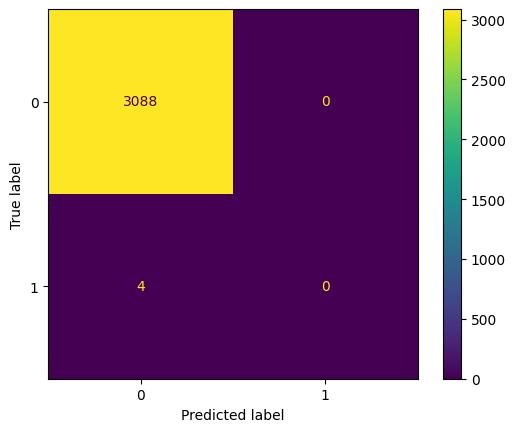

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

#TODO: PASSER en multiclasse
y_pred = my_mlp_model.predict(X_test_2)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_test_2, axis=1)

# Classification report
print(classification_report(y_true, y_pred_classes))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


**ANALYSIS QUESTION** What do you observe? What can you conclude?

"La réponse"

**EXPORTATION DU MODEL**

In [147]:
np.save("X_test.npy", X_test_2)
np.save("Y_test.npy", Y_test_2)
my_mlp_model.save("Model_V1.h5")